## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import cv2
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils import data
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

from scipy import signal

## Data Path

In [2]:
# Path of each track
print(os.listdir("../data"))

['Track1', 'Track2']


## Hyper-parameters

In [3]:
track_no = "2"

dataroot = "../data/Track" + track_no + "/"
ckptroot = "../checkpoint/Track" + track_no + "/"

lr = 1e-4
weight_decay = 1e-5
batch_size = 32
num_workers = 0
test_size = 0.8
shuffle = True

epochs = 80
start_epoch = 1
resume = False

## Handy Functions

In [4]:
def toDevice(datas, device):
    """Enable cuda."""
    imgs, angles = datas
    return imgs.float().to(device), angles.float().to(device)

def zoomInOut(image, scale):
    height, width, _ = image.shape
    center = (width // 2, height // 2)

    # Zoom In
    if scale > 1:
        new_width = int(width * scale)
        new_height = int(height * scale)
        resized = cv2.resize(image, (new_width, new_height))
        
        start_x = max(0, center[0] - width // 2)
        start_y = max(0, center[1] - height // 2)
        end_x = min(new_width, center[0] + width // 2)
        end_y = min(new_height, center[1] + height // 2)
        
        cropped = resized[start_y:end_y, start_x:end_x]

        # Ensure the cropped image has the original dimensions
        result = np.zeros_like(image)
        result[:cropped.shape[0], :cropped.shape[1]] = cropped

    # Zoom Out
    elif scale < 1:
        new_width = int(width * scale)
        new_height = int(height * scale)
        resized = cv2.resize(image, (new_width, new_height))
        
        start_x = (width - new_width) // 2
        start_y = (height - new_height) // 2
        end_x = start_x + new_width
        end_y = start_y + new_height

        # Ensure the resized image has the original dimensions
        result = np.zeros_like(image)
        result[start_y:end_y, start_x:end_x] = resized

    # No zoom, return original image
    else:
        result = image.copy()

    return result

def plotHist(data_dir, col = "steering"):
    # reads CSV file into a single dataframe variable
    data_df = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'),
                          names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

    # Plot histogram of all values in data_df
    plt.figure(figsize=(10, 6))
    plt.hist(data_df[col].values.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of All Values of ' + col)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Calculate the percentage of zero values
    zero_percentage = (data_df[col].values.flatten() == 0).sum() / len(data_df.values.flatten()) * 100
    print(f"Percentage of zero values: {zero_percentage:.2f}%")



# def augment(dataroot, imgName, angle):
#     """Data augmentation."""
#     name = dataroot + 'IMG/' + imgName.split('\\')[-1]
#     current_image = cv2.imread(name)

#     if current_image is None:
#         print(name)
    
#     current_image = current_image[65:-25, :, :]
#     if np.random.rand() < 0.5:
#         current_image = cv2.flip(current_image, 1)
#         angle = angle * -1.0

#     return current_image, angle

def augment(dataroot, imgName, angle):
    """Data augmentation."""
    name = dataroot + 'IMG/' + imgName.split('\\')[-1]
    current_image = cv2.imread(name)

    if current_image is None:
        print(name)

    # Crop image
    current_image = current_image[60:-25, :, :]

    old_shape = current_image.shape
    
    # Randomly apply augmentation techniques
    if np.random.rand() < 0.16:
        # Flip horizontally
        current_image = cv2.flip(current_image, 1)
        angle = angle * -1.0

    if np.random.rand() < 0.16:
        # Zoom
        scale_factor = np.random.uniform(0.8, 1.2)
        current_image = zoomInOut(current_image, scale_factor)
        # print(current_image.shape)

    if np.random.rand() < 0.16:
        # Pan (translation)
        tx = np.random.uniform(-20, 20)
        ty = np.random.uniform(-5, 5)
        translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
        current_image = cv2.warpAffine(current_image, translation_matrix, (current_image.shape[1], current_image.shape[0]))

    if np.random.rand() < 0.16:
        # Rotate
        rotation_angle = np.random.uniform(-10, 10)
        rotation_matrix = cv2.getRotationMatrix2D((current_image.shape[1] / 2, current_image.shape[0] / 2), rotation_angle, 1)
        current_image = cv2.warpAffine(current_image, rotation_matrix, (current_image.shape[1], current_image.shape[0]))
        angle += rotation_angle

    if np.random.rand() < 0.16:
        # Change brightness
        brightness_factor = np.random.uniform(0.5, 1.5)
        current_image = current_image * brightness_factor
        current_image = np.clip(current_image, 0, 255)



    if (old_shape != current_image.shape):
        print("Image size inconsistency detected!")

    return current_image, angle

## Load Data

In [5]:
def load_data(data_dir, test_size):
    """Load training data and train validation split"""
    # reads CSV file into a single dataframe variable
    data_df = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'),
                          names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

    # smooth data signal with `savgol_filter`
    data_df["steering"] = signal.savgol_filter(data_df["steering"].values.tolist(), 51, 11)

    # Divide the data into training set and validation set
    train_len = int(test_size * data_df.shape[0])
    valid_len = data_df.shape[0] - train_len
    trainset, valset = data.random_split(
        data_df.values.tolist(), lengths=[train_len, valid_len])

    return trainset, valset

trainset, valset = load_data(dataroot, test_size)

## Dataset Class

In [6]:
class TripletDataset(data.Dataset):

    def __init__(self, dataroot, samples, transform=None):
        self.samples = samples
        self.dataroot = dataroot
        self.transform = transform

    def __getitem__(self, index):
        batch_samples = self.samples[index]
        steering_angle = float(batch_samples[3])

        center_img, steering_angle_center = augment(self.dataroot, batch_samples[0], steering_angle)
        left_img, steering_angle_left     = augment(self.dataroot, batch_samples[1], steering_angle + 0.4)
        right_img, steering_angle_right   = augment(self.dataroot, batch_samples[2], steering_angle - 0.4)

        center_img = self.transform(center_img)
        left_img   = self.transform(left_img)
        right_img  = self.transform(right_img)

        return (center_img, steering_angle_center), (left_img, steering_angle_left), (right_img, steering_angle_right)

    def __len__(self):
        return len(self.samples)

## Plot Histogram

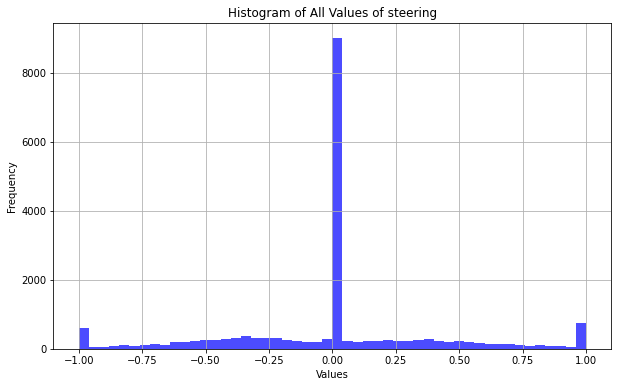

Percentage of zero values: 6.43%


In [7]:
plotHist(dataroot)

## Data Loader

In [8]:
print("╔═════════════════════╗\n║ Prepare dataset ... ║\n╚═════════════════════╝")
def data_loader(dataroot, trainset, valset, batch_size, shuffle, num_workers):
    """Self-Driving vehicles simulator dataset Loader.

    Args:
        trainset: training set
        valset: validation set
        batch_size: training set input batch size
        shuffle: whether shuffle during training process
        num_workers: number of workers in DataLoader

    Returns:
        trainloader (torch.utils.data.DataLoader): DataLoader for training set
        testloader (torch.utils.data.DataLoader): DataLoader for validation set
    """
    transformations = transforms.Compose(
        [transforms.Lambda(lambda x: (x / 127.5) - 1.0)])

    # Load training data and validation data
    training_set = TripletDataset(dataroot, trainset, transformations)
    ##
    print(training_set.__len__())
    ##
    trainloader = DataLoader(training_set,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=num_workers)

    validation_set = TripletDataset(dataroot, valset, transformations)
    valloader = DataLoader(validation_set,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           num_workers=num_workers)

    return trainloader, valloader


trainloader, validationloader = data_loader(dataroot,
                                            trainset, valset,
                                            batch_size,
                                            shuffle,
                                            num_workers)

╔═════════════════════╗
║ Prepare dataset ... ║
╚═════════════════════╝
15502


## Define Model

In [9]:
class MyNetwork(nn.Module):

    def __init__(self):
        super(MyNetwork, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride = 2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride = 2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride = 2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.Dropout(0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features = 64 * 2 * 33, out_features = 100),
            nn.ELU(),
            nn.Linear(in_features = 100, out_features = 50),
            nn.ELU(),
            nn.Linear(in_features = 50, out_features = 10),
            nn.Linear(in_features = 10, out_features = 1)
        )

    def forward(self, input):
        """Forward pass."""
        input = input.view(input.size(0), 3, 75, 320)
        output = self.conv_layers(input)
        # print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output


# Define model
print("╔════════════════════════╗\n║ Initialize model ..... ║\n╚════════════════════════╝")
model = MyNetwork()
print("╔═══════════════════════════════╗\n║ Initializing model done ..... ║\n╚═══════════════════════════════╝")

╔════════════════════════╗
║ Initialize model ..... ║
╚════════════════════════╝
╔═══════════════════════════════╗
║ Initializing model done ..... ║
╚═══════════════════════════════╝


## Define optimizer and criterion

In [10]:
# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
criterion = nn.MSELoss()

## Learning rate scheduler

In [11]:
# learning rate scheduler
scheduler = MultiStepLR(optimizer, milestones=[30, 50], gamma=0.1)

# transfer to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Resume training

In [12]:
if resume:
    print("╔═══════════════════════╗\n║ Load checkpoint ..... ║\n╚═══════════════════════╝")
    checkpoint = torch.load("../input/pretrainedmodels/both-nvidia-model-61.h5",
                            map_location=lambda storage, loc: storage)
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])

## Train the model

In [13]:
class Trainer(object):
    """Trainer."""

    def __init__(self,
                 ckptroot,
                 model,
                 device,
                 epochs,
                 criterion,
                 optimizer,
                 scheduler,
                 start_epoch,
                 trainloader,
                 validationloader):
        """Self-Driving car Trainer.

        Args:
            model:
            device:
            epochs:
            criterion:
            optimizer:
            start_epoch:
            trainloader:
            validationloader:

        """
        super(Trainer, self).__init__()

        self.model = model
        self.device = device
        self.epochs = epochs
        self.ckptroot = ckptroot
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.start_epoch = start_epoch
        self.trainloader = trainloader
        self.validationloader = validationloader

    def train(self):
        """Training process."""
        self.model.to(self.device)
        for epoch in range(self.start_epoch, self.epochs + self.start_epoch):
            
            # Training
            train_loss = 0.0
            self.model.train()

            for local_batch, (centers, lefts, rights) in enumerate(self.trainloader):
                # Transfer to GPU
                centers, lefts, rights = toDevice(centers, self.device), toDevice(
                    lefts, self.device), toDevice(rights, self.device)

                # Model computations
                self.optimizer.zero_grad()
                datas = [centers, lefts, rights]
                for data in datas:
                    imgs, angles = data
                    # print("training image: ", imgs.shape)
                    outputs = self.model(imgs)
                    loss = self.criterion(outputs, angles.unsqueeze(1))
                    loss.backward()
                    self.optimizer.step()

                    train_loss += loss.data.item()

                if local_batch % 100 == 0:

                    print("♯ Epoch: {}/{}    |    💲Loss: {}".format(epoch, epochs, train_loss / (local_batch + 1)))

            self.scheduler.step()

            # Validation
            self.model.eval()
            valid_loss = 0
            with torch.set_grad_enabled(False):
                for local_batch, (centers, lefts, rights) in enumerate(self.validationloader):
                    # Transfer to GPU
                    centers, lefts, rights = toDevice(centers, self.device), toDevice(
                        lefts, self.device), toDevice(rights, self.device)

                    # Model computations
                    self.optimizer.zero_grad()
                    datas = [centers, lefts, rights]
                    for data in datas:
                        imgs, angles = data
                        outputs = self.model(imgs)
                        loss = self.criterion(outputs, angles.unsqueeze(1))

                        valid_loss += loss.data.item()

                    if local_batch % 100 == 0:
                        print("💰Validation Loss: {}".format(valid_loss / (local_batch + 1)))

            print()
            # Save model
            if epoch % 5 == 0 or epoch == self.epochs + self.start_epoch - 1:

                state = {
                    'epoch': epoch + 1,
                    'state_dict': self.model.state_dict(),
                    'optimizer': self.optimizer.state_dict(),
                    'scheduler': self.scheduler.state_dict(),
                }

                self.save_checkpoint(state)

    def save_checkpoint(self, state):
        """Save checkpoint."""
        print("╔═══════════════════════╗\n║ Save checkpoint ..... ║\n╚═══════════════════════╝")
        if not os.path.exists(self.ckptroot):
            os.makedirs(self.ckptroot)

        torch.save(state, self.ckptroot + 'both-nvidia-model-{}.h5'.format(state['epoch']))


In [14]:
print("╔══════════════════════╗\n║ Start training ..... ║\n╚══════════════════════╝")
trainer = Trainer(ckptroot,
                  model,
                  device,
                  epochs,
                  criterion,
                  optimizer,
                  scheduler,
                  start_epoch,
                  trainloader,
                  validationloader)
trainer.train()

╔══════════════════════╗
║ Start training ..... ║
╚══════════════════════╝
♯ Epoch: 1/80    |    💲Loss: 16.850257396697998
♯ Epoch: 1/80    |    💲Loss: 4.105334107754844
♯ Epoch: 1/80    |    💲Loss: 2.763605990479538
♯ Epoch: 1/80    |    💲Loss: 2.220140836192326
♯ Epoch: 1/80    |    💲Loss: 1.9118129291067694
💰Validation Loss: 0.9363619089126587
💰Validation Loss: 1.008902090020699

♯ Epoch: 2/80    |    💲Loss: 0.6767239570617676
♯ Epoch: 2/80    |    💲Loss: 0.9190592883837105
♯ Epoch: 2/80    |    💲Loss: 0.8455135020524708
♯ Epoch: 2/80    |    💲Loss: 0.8873101820630884
♯ Epoch: 2/80    |    💲Loss: 0.8560401943705028
💰Validation Loss: 0.5395584106445312
💰Validation Loss: 0.7234128999828112

♯ Epoch: 3/80    |    💲Loss: 0.6860863566398621
♯ Epoch: 3/80    |    💲Loss: 0.7730799473010668
♯ Epoch: 3/80    |    💲Loss: 0.7990877977317542
♯ Epoch: 3/80    |    💲Loss: 0.7678109416212157
♯ Epoch: 3/80    |    💲Loss: 0.7692485940259443
💰Validation Loss: 0.9195447266101837
💰Validation Loss: 0.69